04.04.2022 - Notebook by Aadam

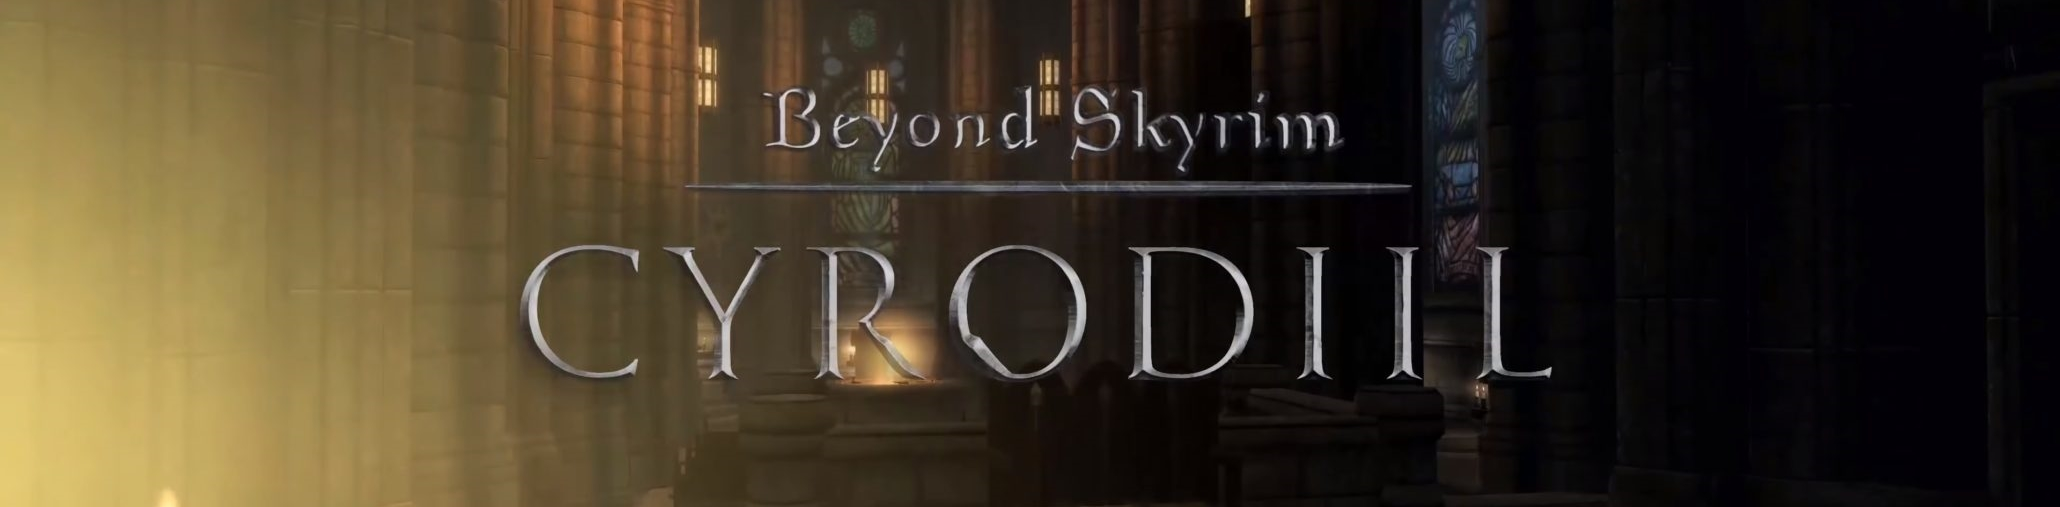

# Dynamic Web Scraping & (pre-trained) Sentiment Analysis

In this notebook, I used Selenium's web drivers to dynamically scrape information from the YouTube comment section of the following video: Cyrodiil 11/11 Anniversary Trailer. Sentiment analysis is then performed on the data using a pre-trained machine learning model (from https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment).

## 1. Data Acquisition

### 1.1. Imports and data capture

In [1]:
# imports
from selenium import webdriver
import time
from bs4 import BeautifulSoup as bs
import pandas as pd

In [2]:
# browser set to Microsoft Edge webdriver's download location
driver = webdriver.Edge(r'C:\Users\aadam\Downloads\edgedriver_win64\msedgedriver.exe')
driver.maximize_window()

# our requested url
driver.get("https://www.youtube.com/watch?v=mLu0jkt7LPM")

# accepting cookie pop-up
driver.implicitly_wait(10)
cookie = driver.find_element_by_xpath('//yt-formatted-string[contains(text(), "I agree")]').click()

# scroll to bottom of video desc. to begin comment loading
driver.execute_script("window.scrollTo(0, 1080)") 
time.sleep(1)
driver.execute_script("window.scrollTo(0, 1080)") 
time.sleep(1)

# scrolls down 25 times by 1080px to load comments
for i in range(50):
    driver.execute_script("window.scrollBy(0, 1080)")
    time.sleep(1)

# capturing the Selenium output into a BeautifulSoup variable
source = driver.page_source
page = bs(source)

driver.close()

C:\Users\aadam\AppData\Local\Temp/ipykernel_12404/1070519116.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Edge(r'C:\Users\aadam\Downloads\edgedriver_win64\msedgedriver.exe')
C:\Users\aadam\AppData\Local\Temp/ipykernel_12404/1070519116.py:10: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  cookie = driver.find_element_by_xpath('//yt-formatted-string[contains(text(), "I agree")]').click()


We have created a bot that is able to scrape information from a dynamic webpage. That is, a webpage which loads content based on certain conditions. For example, the YouTube comments will not load until you scroll down to view them. When dealing with content like this, we need to create bots that can automatically navigate through webpages and access this content. This is what we have done in the above code.

### 1.2. Creating a dataframe from comment text

In [3]:
commentList = page.find_all('ytd-expander')

# generating the comment content list
commentContent = []

for comment in commentList:
    if comment.find_all(id=='paid-comment-images') and comment.text:
        commentContent.append(comment.text)
        
# removing the description and info entries
commentContent = commentContent[2:]
commentContent = commentContent[:-1]

In [4]:
# turning our list into a dataframe and cleaning it
df = pd.DataFrame(commentContent, columns = ['Comment'])
df['Comment'] = df['Comment'].str.replace('\n', '')
df['Comment'] = df['Comment'].str.replace('Show lessRead more', '')
df.head(5)

,Comment
0,Beyond Skyrim is so cool - love the idea of re...
1,This voice actor is magnificent! This is what ...
2,Bethesda should just go ahead and call this ca...
3,"Titus Mede: ""But even then, we fought as one.""..."
4,I'm more hyped for this than any AAA release a...


In [5]:
print('We have loaded in a total of {} comments from the webpage.'.format(len(df)))

We have loaded in a total of 479 comments from the webpage.


### 1.3. (Optional) Converting to a .csv file

In [6]:
# saving our dataframe to a .csv file
df.to_csv('cyrodiil_comments.csv')

## 2. Sentiment Analysis

### 2.1. Imports and data capture

In [7]:
# imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import seaborn as sns

### 2.2. Model instantiation

Note: this pre-trained BERT model ranks sentiment on a scale from 1 (highly negative) to 5 (highly positive).

In [8]:
# instantiating tokeniser and ML model from website
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

### 2.3. Model application

In [9]:
# applying model to our comment dataframe and collecting sentiment values

sentimentList = []

for index in range(len(df['Comment'])):
    tokens = tokenizer.encode(df['Comment'][index], return_tensors='pt')
    result = model(tokens)
    sentimentList.append(int(torch.argmax(result.logits)+1))

### 2.4. Appending sentiment values to dataframe

In [10]:
# converting our list into a pandas series
sentimentColumn = pd.Series(sentimentList)

# inserting our series into our dataframe
df.insert(loc=0, column = 'Sentiment', value = sentimentColumn)
df.head(5)

,Sentiment,Comment
0,5,Beyond Skyrim is so cool - love the idea of re...
1,5,This voice actor is magnificent! This is what ...
2,5,Bethesda should just go ahead and call this ca...
3,4,"Titus Mede: ""But even then, we fought as one.""..."
4,5,I'm more hyped for this than any AAA release a...


### 2.5. (Optional) Converting to a .csv file

In [11]:
# saving our dataframe to a .csv file
df.to_csv('cyrodiil_comments.csv')

### 2.6. Basic visualisation

Average Sentiment: 4.1/5.0


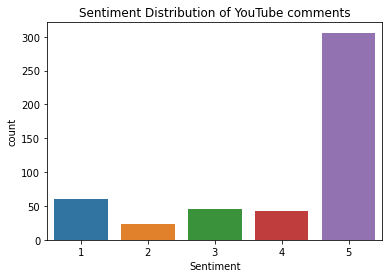

In [12]:
# plotting a count of the values in the Sentiment column
sentimentDistribution = sns.countplot(x = df['Sentiment'])
sentimentDistribution.set_title('Sentiment Distribution of YouTube comments')

# calculating an average sentiment value
sentimentAverage = round(sum(sentimentList) / len(sentimentList), 1)
print('Average Sentiment: {}/5.0'.format(sentimentAverage))

### 2.7. Notes

The model has calculated an average sentiment value of 3.8/5.0 from the top 479 YouTube comments, suggesting a heavily positively skewed dataset. Upon manual inspection of the comment content (via the previously generated .csv file), I found that the machine learning model, whilst generally accurate, actually underestimated the positivity among the comment section.

### 2.8. Weaknesses

* It is common for users to use vulgar terms when expressing joy (see examples below) which frequently confused the ML model, causing it to mistakenly assign positive comments a negative sentiment score.

    * e.g. *Fuck I'm legit in tears. I made a promise to ya Martin; And I intent on following it.*

* Additionally, negative references to Skyrim: Anniversary Edition or Bethesda Game Studios marked as such as the model is not able to pick up when sentiment is aimed at Beyond Skyrim: Cyrodiil in particular.

    * e.g. *The Beyond skyrim team makes bethesda look like shit lmao*

* Another (understandable) point of confusion for the ML was when a comment would include a quote of some sort. These types of comments were typically referencing lines from old TES games and content.

    * e.g. *\"Halt right there Citizen, it's dangerous to go alone, here take this" **pickpocket skooma into citizens pockets** -Me as a Riten Guard*

* Finally, a selection of seemingly neutral comments were tagged as having highly negative sentiment despite no clear indicators of negativity within them.

    * e.g. *What's the soundtrack for this? Was it released yet?*

# 3. Conclusion

Overall, my first experience with a pre-trained ML model was interesting. It seems that the sentiment analysis it performs has a very limited scope of use and some significant drawback (inability to interpret where criticism is directed, slang, quotes etc.). However, in more sanitised cases (i.e. without those hindrances), the model performs well when categorising the sentiments of inputted text.